# Проект по предсказанию токсичности соединений
Что нужно сделать:


1. Проанализировать данные, + за визуализацию
2. Предобработать данные, чтобы улучшить качество модели. + за инсайты, если что-то найдется
3. Обучить модель и провалидировать ее. Метрика: RMSE
4. Проверить модель на test данных и прислать результаты вместе с ноутбуком



## Библиотеки и загрузка данных

rdkit – библиотека для работы с химическими данными.

In [1]:
!pip3 install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 15.6 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

import warnings
warnings.filterwarnings('ignore')

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_predict
# from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, roc_auc_score, roc_curve
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# из библиотеки google.colab импортируем класс files
from google.colab import drive
#drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [5]:
train = pd.read_csv("/content/gdrive/MyDrive/Date/train(2).csv")
train.head(5)

,SMILES,activity
0,OCC=C,5.0
1,CO/N=C(/C(=O)OC)\C1=C(COC2=C(C)C=CC=C2)C=CC=C1,94.0
2,COC(=O)NS(=O)(=O)C1=CC=C(N)C=C1,5.4
3,CCCCC(CC)C(O)=O,-8.2
4,COC(=O)C1=C(CC(C)C)C(C2=NCCS2)=C(N=C1C(F)F)C(F...,26.2


## Анализ данных

Здесь будет ваше решение по анализу: графики, числа, визуализации. Если найдете что-то интересное, можно написать текстом.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMILES    759 non-null    object 
 1   activity  759 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.0+ KB


In [7]:
train.isnull().sum() #смотрим пропуски

,0
SMILES,0
activity,0


In [8]:
print ("Duplicate values in df are:" , train.duplicated().sum()) #смотрим дупликаты

Duplicate values in df are: 0


In [9]:
# # Базовая статистика
print(train.describe())

         activity
count  759.000000
mean    40.691304
std     36.150662
min    -38.300000
25%     10.750000
50%     30.100000
75%     69.550000
max    111.000000


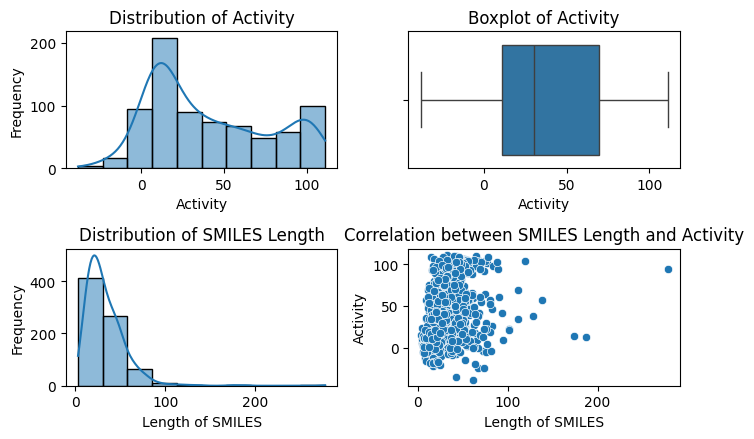

In [10]:
# Задаем размер фигуры и количество подграфиков (2 строки и 2 столбца)
fig, axes = plt.subplots(2, 2, figsize=(7, 4.5))

# Визуализация распределения активности
sns.histplot(train['activity'], bins=10, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Activity')
axes[0, 0].set_xlabel('Activity')
axes[0, 0].set_ylabel('Frequency')

# Визуализация разброса значений активности
sns.boxplot(x=train['activity'], ax=axes[0, 1])
axes[0, 1].set_title('Boxplot of Activity')
axes[0, 1].set_xlabel('Activity')

# Пример распределения длины SMILES строк
train['smiles_length'] = train['SMILES'].apply(len)
sns.histplot(train['smiles_length'], bins=10, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of SMILES Length')
axes[1, 0].set_xlabel('Length of SMILES')
axes[1, 0].set_ylabel('Frequency')

# Корреляция между длиной SMILES и активностью
sns.scatterplot(x=train['smiles_length'], y=train['activity'], ax=axes[1, 1])
axes[1, 1].set_title('Correlation between SMILES Length and Activity')
axes[1, 1].set_xlabel('Length of SMILES')
axes[1, 1].set_ylabel('Activity')

# Автоматическое подстраивание элементов подграфиков
plt.tight_layout()
# Показать все графики
plt.show()

## Предобработка данных

SMILES – это форма записи молекулы текстом. Модели не понимают текст (если мы не говорим о специальных моделях), поэтому текст нужно превратить в числа. Один из способов превратить молекулы в числа – это fingerprints.

In [11]:
def smiles_to_fp(smiles):
    '''Convert SMILES to Morgan fingerprints'''
    return np.array([AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2, nBits=1024) for s in smiles])

X_train = smiles_to_fp(train.SMILES)

[13:59:33] DEPRECATION WARNING: please use MorganGenerator
[13:59:33] DEPRECATION WARNING: please use MorganGenerator
[13:59:33] DEPRECATION WARNING: please use MorganGenerator
[13:59:33] DEPRECATION WARNING: please use MorganGenerator
[13:59:33] DEPRECATION WARNING: please use MorganGenerator
[13:59:33] DEPRECATION WARNING: please use MorganGenerator
[13:59:33] DEPRECATION WARNING: please use MorganGenerator
[13:59:33] DEPRECATION WARNING: please use MorganGenerator
[13:59:33] DEPRECATION WARNING: please use MorganGenerator
[13:59:33] DEPRECATION WARNING: please use MorganGenerator
[13:59:33] DEPRECATION WARNING: please use MorganGenerator
[13:59:33] DEPRECATION WARNING: please use MorganGenerator
[13:59:33] DEPRECATION WARNING: please use MorganGenerator
[13:59:33] DEPRECATION WARNING: please use MorganGenerator
[13:59:33] DEPRECATION WARNING: please use MorganGenerator
[13:59:33] DEPRECATION WARNING: please use MorganGenerator
[13:59:33] DEPRECATION WARNING: please use MorganGenerat

In [12]:
# # Вывод первых нескольких строк, добавилась длина так как визуализировали ее и анализировали
print(train.head(5))

                                              SMILES  activity  smiles_length
0                                              OCC=C       5.0              5
1     CO/N=C(/C(=O)OC)\C1=C(COC2=C(C)C=CC=C2)C=CC=C1      94.0             46
2                    COC(=O)NS(=O)(=O)C1=CC=C(N)C=C1       5.4             31
3                                    CCCCC(CC)C(O)=O      -8.2             15
4  COC(=O)C1=C(CC(C)C)C(C2=NCCS2)=C(N=C1C(F)F)C(F...      26.2             51


In [ ]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

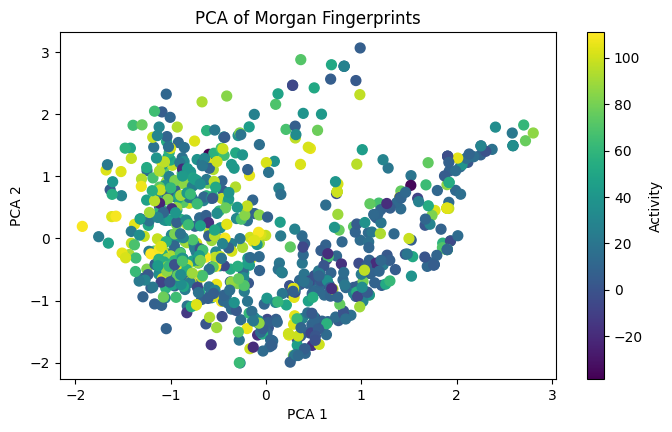

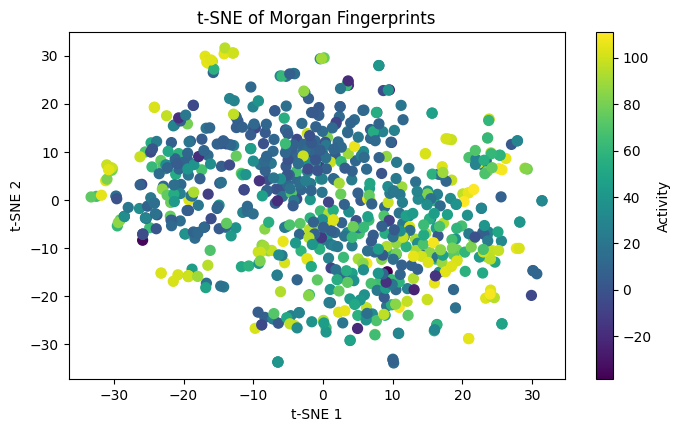

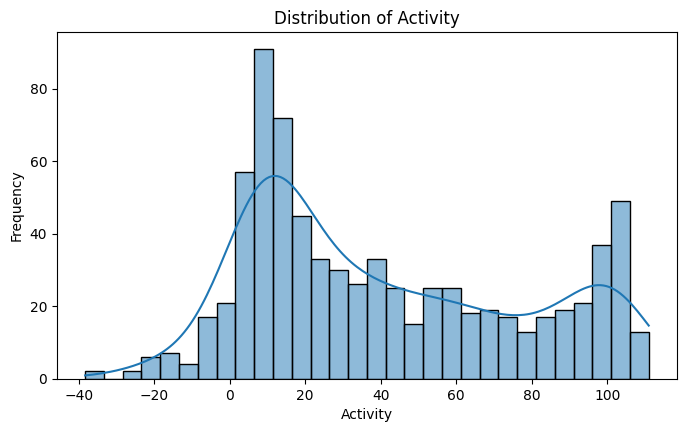

In [13]:
# снижаем размерность для визуализации
#PCA для визуализации
def plot_pca(X, y):
    pca = PCA(n_components=2, svd_solver='auto', whiten=True, random_state=42)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(8, 4.5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50)
    plt.colorbar(label='Activity')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title('PCA of Morgan Fingerprints')
    plt.show()

# t-SNE для визуализации
def plot_tsne(X, y):
    tsne = TSNE(n_components=2, perplexity=30, n_iter=700, random_state=42)
    X_tsne = tsne.fit_transform(X)
    plt.figure(figsize=(8, 4.5))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', s=50)
    plt.colorbar(label='Activity')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title('t-SNE of Morgan Fingerprints')
    plt.show()

# Визуализация PCA
plot_pca(X_train, train.activity)

# Визуализация t-SNE
plot_tsne(X_train, train.activity)

# Распределение активности
def plot_activity_distribution(y):
    plt.figure(figsize=(8, 4.5))
    sns.histplot(y, kde=True, bins=30)
    plt.xlabel('Activity')
    plt.ylabel('Frequency')
    plt.title('Distribution of Activity')
    plt.show()

# Визуализация распределения активности
plot_activity_distribution(train.activity)

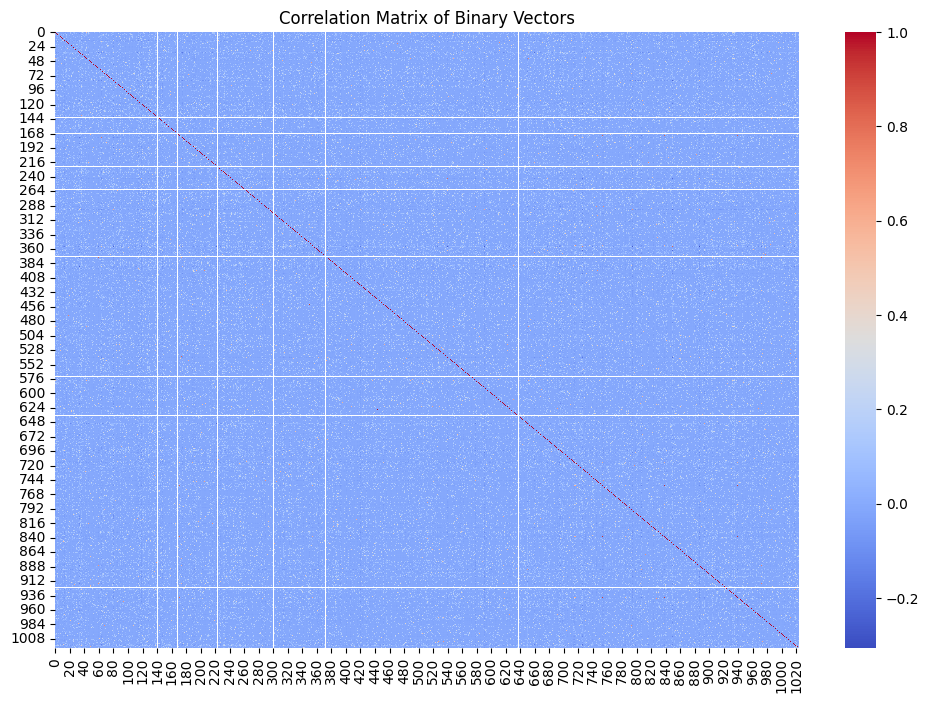

In [15]:
# Проведем анализ корреляции (метод Пирсон)
def analyze_correlation(X):
    df = pd.DataFrame(X)
    correlation_matrix = df.corr(method='pearson')
    return correlation_matrix

# Визуализация корреляционной матрицы
def plot_correlation_matrix(correlation_matrix):
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.2f')
    plt.title('Correlation Matrix of Binary Vectors')
    plt.show()

# Анализ и визуализация корреляции
correlation_matrix = analyze_correlation(X_train)
plot_correlation_matrix(correlation_matrix)

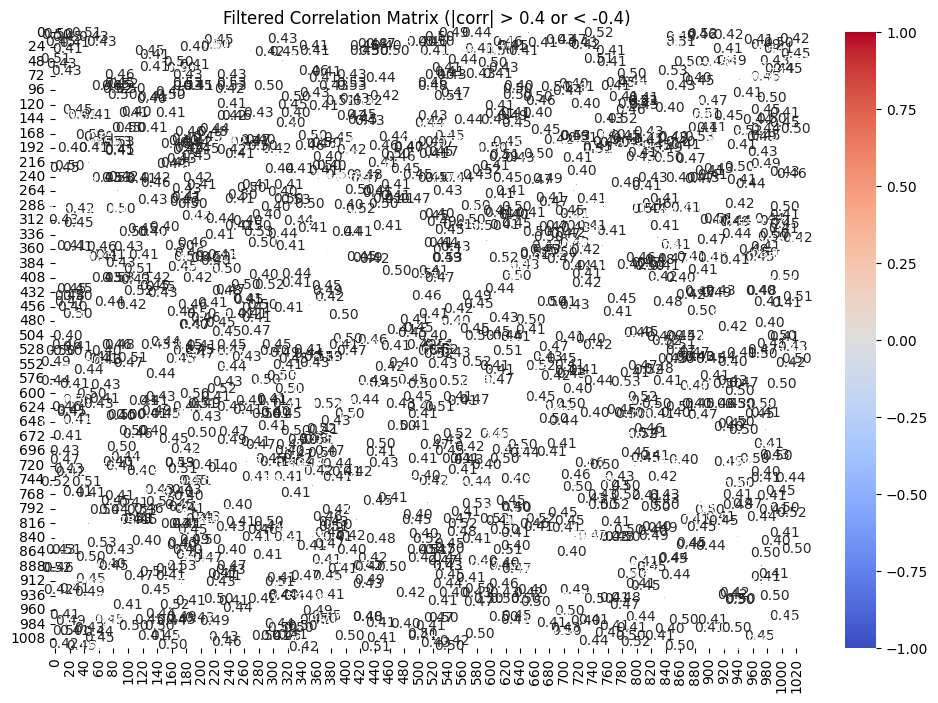

In [16]:
#  для лучшей визуализации отбираем признаки с корреляцией больше 0.4 и меньше -0.4
# Отбор корреляций больше 0.4 и меньше -0.4
def filter_correlations(correlation_matrix, threshold=0.4):
    filtered_corr = correlation_matrix[((correlation_matrix > threshold) | (correlation_matrix < -threshold)) & (correlation_matrix != 1.0)]
    return filtered_corr

# Визуализация корреляционной матрицы
def plot_filtered_correlation_matrix(filtered_corr):
    plt.figure(figsize=(12, 8))
    sns.heatmap(filtered_corr, cmap='coolwarm', annot=True, fmt='.2f', vmin=-1, vmax=1)
    plt.title('Filtered Correlation Matrix (|corr| > 0.4 or < -0.4)')
    plt.show()

# Анализ и визуализация корреляции
correlation_matrix = analyze_correlation(X_train)
filtered_corr = filter_correlations(correlation_matrix)
plot_filtered_correlation_matrix(filtered_corr)

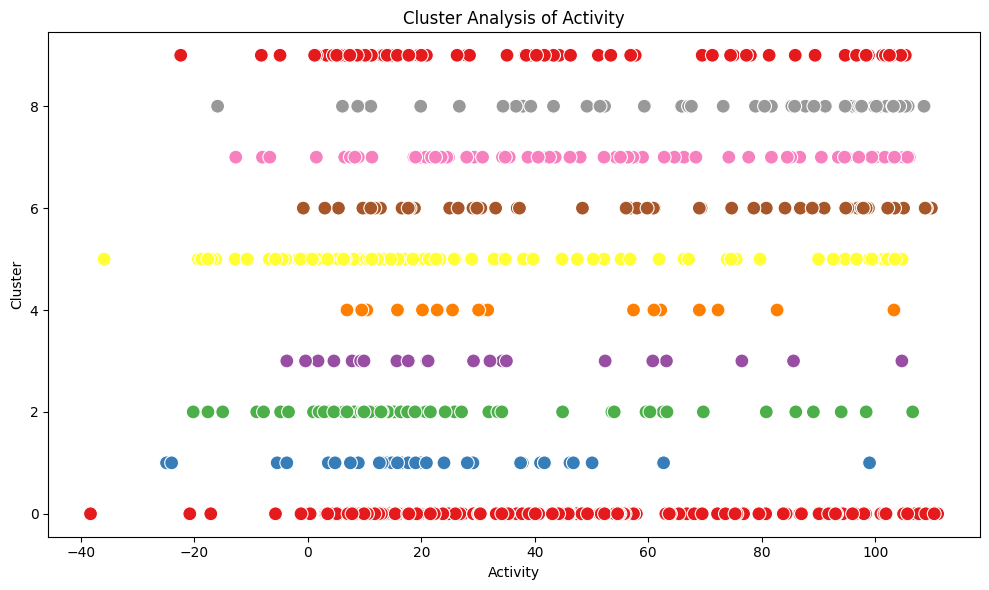

In [ ]:
# проведем визуализацию с помощью Кластерного анализа- K-means
def cluster_analysis(X, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(X)
    return clusters

# Выбор числа кластеров
num_clusters = 10
# Проведение кластерного анализа
clusters = cluster_analysis(X_train, num_clusters)
# Добавление информации о кластерах в данные
train['cluster'] = clusters

# Визуализация кластеров
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train, x='activity', y='cluster', hue='cluster', palette='Set1', s=100, legend=False)
plt.xlabel('Activity')
plt.ylabel('Cluster')
plt.title('Cluster Analysis of Activity')
plt.tight_layout()
plt.show()

In [17]:
# Снижаем размерность для добавлеения новых признаков
# PCA
pca = PCA(n_components=2, svd_solver='auto', whiten=True, random_state=42)
X_pca = pca.fit_transform(X_train)

# t-SNE
tsne = TSNE(n_components=2,  perplexity=30, n_iter=700, random_state=42)
X_tsne = tsne.fit_transform(X_train)

# Добавление новых признаков в X_train
X_train = np.concatenate((X_train, X_pca, X_tsne), axis=1)

In [18]:
# Шаг 1: Удаление признаков с низкой дисперсией
threshold = 0.16
selector = VarianceThreshold(threshold)
X_high_variance = selector.fit_transform(X_train)

# Получение индексов признаков с высокой дисперсией
high_variance_indices = selector.get_support(indices=True)

# Преобразование в DataFrame для работы с корреляционной матрицей
df = pd.DataFrame(X_high_variance)

# Шаг 2: Удаление признаков с высокой корреляцией
# Вычисление корреляционной матрицы
corr_matrix = df.corr().abs()

# Создание маски для выборки верхнего треугольника матрицы корреляций
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Нахождение признаков с корреляцией выше 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Удаление этих признаков
df_reduced = df.drop(columns=to_drop)

# Вывод результатов
print(f"Number of features before removing low variance features: {X_train.shape[1]}")
print(f"Number of features after removing low variance features: {X_high_variance.shape[1]}")
print(f"Number of features after removing highly correlated features: {df_reduced.shape[1]}")

# Пример данных до и после удаления признаков
print("\nColumns dropped due to high correlation:")
print(to_drop)

print("\nExample of original feature vector:")
print(X_train[0])

print("\nExample of feature vector after removing low variance features:")
print(X_high_variance[0])

print("\nExample of feature vector after removing highly correlated features:")
print(df_reduced.iloc[0].values)


Number of features before removing low variance features: 1028
Number of features after removing low variance features: 18
Number of features after removing highly correlated features: 18

Columns dropped due to high correlation:
[]

Example of original feature vector:
[ 0.          0.          0.         ... -1.32339004 -4.4239645
 10.06226349]

Example of feature vector after removing low variance features:
[ 0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.76004319 -1.32339004 -4.4239645  10.06226349]

Example of feature vector after removing highly correlated features:
[ 0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.76004319 -1.32339004 -4.4239645  10.06226349]


          Set       RMSE        MAE    MedAE
0       Train  11.189488   8.529881   7.1020
1  Validation  28.521807  22.493706  18.8975


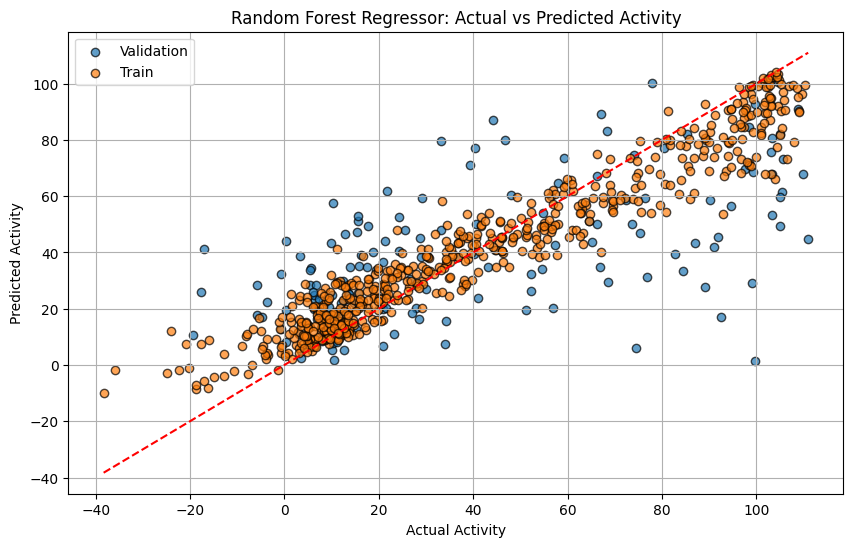

In [19]:
y = train['activity']
# Преобразование обратно в numpy массив для обучения модели
X_reduced = df_reduced.to_numpy()

# Разделение на тренировочную и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Обучение модели RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Прогнозы на всех выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Вычисление метрик
def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    return rmse, mae, medae

metrics_train = compute_metrics(y_train, y_train_pred)
metrics_val = compute_metrics(y_val, y_val_pred)

# Таблица метрик
metrics_df = pd.DataFrame({
    'Set': ['Train', 'Validation'],
    'RMSE': [metrics_train[0], metrics_val[0]],
    'MAE': [metrics_train[1], metrics_val[1]],
    'MedAE': [metrics_train[2], metrics_val[2]],
    })

print(metrics_df)

# Визуализация результатов
plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_test_pred, edgecolor='k', alpha=0.7, label='Test')
plt.scatter(y_val, y_val_pred, edgecolor='k', alpha=0.7, label='Validation')
plt.scatter(y_train, y_train_pred, edgecolor='k', alpha=0.7, label='Train')
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--')
plt.xlabel('Actual Activity')
plt.ylabel('Predicted Activity')
plt.title('Random Forest Regressor: Actual vs Predicted Activity')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
test_df = pd.read_csv("/content/gdrive/MyDrive/Date/test_only_smiles.csv")
test_df.head(5)

,Unnamed: 0,SMILES
0,0,CC(O)CCO
1,1,CCCCOCCOC(=O)COC1=C(Cl)C=C(Cl)C=C1
2,2,CO/N=C(/C1=NOCCO1)\C2=C(OC3=NC=NC(OC4=CC=CC=C4...
3,3,C=CC(=O)NCNC(=O)C=C
4,4,CC1=CC(=CC=C1)[N+]([O-])=O


In [21]:
# def smiles_to_fp(smiles):
#     '''Convert SMILES to Morgan fingerprints'''
#     return np.array([AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2, nBits=1024) for s in smiles])

# X_train = smiles_to_fp(train.SMILES)

In [22]:
X_test = smiles_to_fp(test_df.SMILES)

[14:07:33] DEPRECATION WARNING: please use MorganGenerator
[14:07:33] DEPRECATION WARNING: please use MorganGenerator
[14:07:33] DEPRECATION WARNING: please use MorganGenerator
[14:07:33] DEPRECATION WARNING: please use MorganGenerator
[14:07:33] DEPRECATION WARNING: please use MorganGenerator
[14:07:33] DEPRECATION WARNING: please use MorganGenerator
[14:07:33] DEPRECATION WARNING: please use MorganGenerator
[14:07:33] DEPRECATION WARNING: please use MorganGenerator
[14:07:33] DEPRECATION WARNING: please use MorganGenerator
[14:07:33] DEPRECATION WARNING: please use MorganGenerator
[14:07:33] DEPRECATION WARNING: please use MorganGenerator
[14:07:33] DEPRECATION WARNING: please use MorganGenerator
[14:07:33] DEPRECATION WARNING: please use MorganGenerator
[14:07:33] DEPRECATION WARNING: please use MorganGenerator
[14:07:33] DEPRECATION WARNING: please use MorganGenerator
[14:07:33] DEPRECATION WARNING: please use MorganGenerator
[14:07:33] DEPRECATION WARNING: please use MorganGenerat

**Повторяем все для данных из ТЕСТОВОГО ФАЙЛА**

In [30]:
# Снижаем размерность для добавлеения новых признаков в X_test
# PCA
pca = PCA(n_components=2, svd_solver='auto', whiten=True, random_state=42)
X_pca_test = pca.fit_transform(X_test)
# t-SNE
tsne = TSNE(n_components=2,  perplexity=30, n_iter=700, random_state=42)
X_tsne_test = tsne.fit_transform(X_test)

# Добавление новых признаков в X_train
X_test = np.concatenate((X_test, X_pca_test, X_tsne_test), axis=1)

In [31]:
# Шаг 1: Удаление признаков с низкой дисперсией
threshold = 0.16
selector = VarianceThreshold(threshold)
X_high_variance_test = selector.fit_transform(X_test)

# Получение индексов признаков с высокой дисперсией
high_variance_indices_test = selector.get_support(indices=True)

# Преобразование в DataFrame для работы с корреляционной матрицей
df_test = pd.DataFrame(X_high_variance)

# Шаг 2: Удаление признаков с высокой корреляцией
# Вычисление корреляционной матрицы
corr_matrix_test = df_test.corr().abs()

# Создание маски для выборки верхнего треугольника матрицы корреляций
upper_test = corr_matrix_test.where(np.triu(np.ones(corr_matrix_test.shape), k=1).astype(bool))

# Нахождение признаков с корреляцией выше 0.9
to_drop_test = [column for column in upper.columns if any(upper[column] > 0.9)]

# Удаление этих признаков
df_reduced_test = df.drop(columns=to_drop_test)

# Вывод результатов
print(f"Number of features before removing low variance features: {X_test.shape[1]}")
print(f"Number of features after removing low variance features: {X_high_variance_test.shape[1]}")
print(f"Number of features after removing highly correlated features: {df_reduced_test.shape[1]}")

# Пример данных до и после удаления признаков
print("\nColumns dropped due to high correlation:")
print(to_drop_test)

print("\nExample of original feature vector:")
print(X_test[0])

print("\nExample of feature vector after removing low variance features:")
print(X_high_variance_test[0])

print("\nExample of feature vector after removing highly correlated features:")
print(df_reduced_test.iloc[0].values)


Number of features before removing low variance features: 22
Number of features after removing low variance features: 22
Number of features after removing highly correlated features: 18

Columns dropped due to high correlation:
[]

Example of original feature vector:
[  0.           0.           1.           0.           0.
   0.           0.           0.           0.           0.
   1.           0.           0.           0.           0.76004319
  -1.32339004  -4.4239645   10.06226349  -0.60657358  -0.5181432
 -14.26111794  -7.61977816]

Example of feature vector after removing low variance features:
[  0.           0.           1.           0.           0.
   0.           0.           0.           0.           0.
   1.           0.           0.           0.           0.76004319
  -1.32339004  -4.4239645   10.06226349  -0.60657358  -0.5181432
 -14.26111794  -7.61977816]

Example of feature vector after removing highly correlated features:
[ 0.          0.          1.          0.       

**Обучение модели RandomForestRegressor  на данных из ТЕСТОВОГО ФАЙЛА**

In [32]:
y = train['activity']
# Преобразование обратно в numpy массив для обучения модели
X_test = df_reduced_test.to_numpy()

# Обучение модели RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_test, y)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print("Метрики модели:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

Метрики модели:
MAE: 8.2795
MSE: 118.7238
RMSE: 10.8960


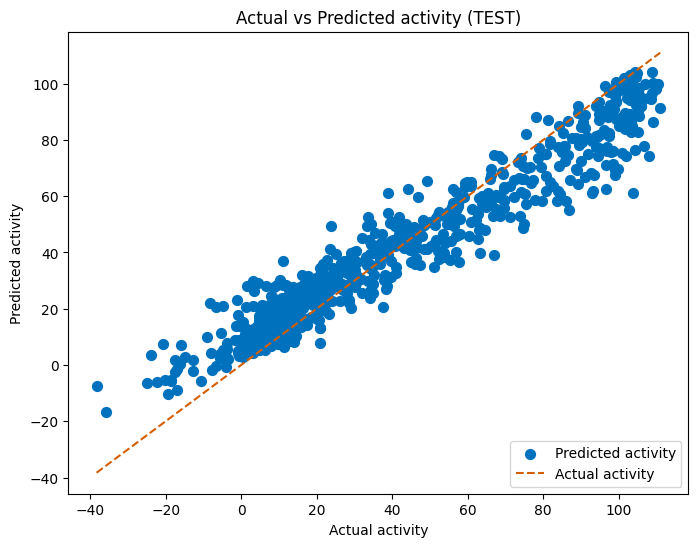

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, color='#0072BD', s=50, label='Predicted activity')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='#D55E03', linestyle='--', label='Actual activity')
plt.xlabel('Actual activity')
plt.ylabel('Predicted activity')
plt.title('Actual vs Predicted activity (TEST)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# model = RandomForestRegressor()
# model.fit(X_train, train.activity)

RandomForestRegressor()

In [ ]:
X_train = df_reduced.to_numpy()

In [ ]:
# Обучение модели RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, train.activity)

RandomForestRegressor(random_state=42)

## Обучение модели

In [ ]:
from sklearn.ensemble import RandomForestRegressor


In [ ]:
model = RandomForestRegressor()
model.fit(X_train, train.activity)

RandomForestRegressor()

## Валидация

In [ ]:
from sklearn.metrics import mean_squared_error